In [3]:
# Copyright (c) 2015, Cordoba Astronomical Observatory.  All rights reserved.
#                    Unauthorized reproduction prohibited. 
# NAME:
#        aligo-vs-glade
# PURPOSE:
#        "Toritos Scheduler White catalog loader
#
# CATEGORY:
#	     Program.
#
# COMPILING SEQUENCE:
# 	     ipython notebook
#
# INPUTS:
#
#
# MODIFICATION HISTORY:
# 	Written by:	Mariano Dominguez, July 2015
#   from previuos version using White Catalog January 2014.
#   Any inquirities send an e-mail to mardom@oac.uncor.edu
#

# Modified by Bruno Sanchez, October 2015

In [4]:
# Global paths and constants
data_path = '.'
# Load useful packages
import os
import numpy as np
import math as m

import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

import seaborn
%matplotlib inline

/home/bruno/.virtualenvs/alertreport/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
#graphic output directory.
import conf as cf

plots = cf.plots
if not os.path.isdir(plots):
    os.mkdir(plots)

In [6]:
import time
print (time.strftime("%d/%m/%Y"))
print (time.strftime("%H:%M:%S"))

macon_date=time.strftime("%Y/%m/%d %H:%M:%S")

print 

10/01/2016
21:36:45



In [7]:
import ephem
macon = ephem.Observer()
macon.lat = cf.macon_lat
macon.lon = cf.macon_lon
macon.elevation = cf.macon_elevation

# extracting the correct values. WEIRD
print float(ephem.degrees(macon.lon*180./m.pi)), float(ephem.degrees(macon.lat*180./m.pi))

-64.5 -31.4


In [8]:
sun = ephem.Sun()
sun.compute(macon)
print sun.a_ra, sun.a_dec
sun_coords = SkyCoord(str(sun.a_ra), str(sun.a_dec), unit=(u.hourangle, u.deg))

print "Sun coordinates are = {}".format(sun_coords.to_string('hmsdms'))

moon = ephem.Moon()
moon.compute(macon)
moon_coords = SkyCoord(str(moon.a_ra), str(moon.a_dec), unit=(u.hourangle, u.deg))

print "Moon coordinates are = {}".format(moon_coords.to_string('hmsdms'))

19:26:29.28 -21:56:58.9
Sun coordinates are = 19h26m29.28s -21d56m58.9s
Moon coordinates are = 20h14m13.41s -15d48m31.8s


This part intends to calculate the rising and setting of the sun at the given date and at Macon.
Since the big errors and differences for the actual setting and rising times of the sun here, we don't trust it at all. Anyway it is not used for any kind of calculation.

In [9]:
sunrise, sunset = macon.next_rising(sun), macon.next_setting(sun)

print "The time of sunset is {}, \nand the time of sunrise is {}".format(sunset, sunrise)

The time of sunset is 2016/1/11 23:26:59, 
and the time of sunrise is 2016/1/11 09:24:20


In [10]:
# at sunset 
alpha_zenith_sunset = sun_coords.ra + 105.*u.deg
alpha_observable_min = alpha_zenith_sunset - 40.*u.deg

In [11]:
# at sunrise
alpha_zenith_sunrise = sun_coords.ra - 105.*u.deg
alpha_observable_max = alpha_zenith_sunrise + 40.*u.deg

In [12]:
print alpha_observable_min.hour, alpha_observable_max.hour

23.7748 15.1081333333


In [13]:
white_cat= cf.catalog

white_table = ascii.read(white_cat, delimiter=' ', format='commented_header')#, data_start=2
white_table

PGC,Name,RA,Dec,Type,App_Mag,Maj_Diam_a,err_Maj_Diam,Min_Diam_b,err_Min_Diam,b/a,err_b/a,PA,Abs_Mag,Dist,err_Dist,err_App_Mag,err_Abs_Mag
float64,string224,float64,float64,string32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.0,UGC12889,0.00047,47.2745,3.1,13.31,1.546,0.498,1.314,nan,0.85,0.1,nan,-21.05,72.458,10.869,0.61,0.61
4.0,PGC000004,0.00096,23.08764,5.0,15.39,0.851,0.078,0.186,nan,0.219,0.015,nan,-18.68,63.264,13.918,0.39,0.4
6.0,PGC000006,0.00058,15.88165,-1.0,15.23,0.457,0.169,0.324,nan,0.708,0.082,nan,-19.46,84.181,18.52,0.34,0.35
7.0,PGC000007,0.00122,-0.08326,-3.2,15.54,0.575,0.093,0.467,nan,0.813,0.056,nan,-19.46,97.347,21.416,0.33,0.34
10.0,PGC000010,0.00217,-0.04057,-3.2,15.56,0.562,0.078,0.446,nan,0.794,0.037,nan,-19.46,98.25,21.615,0.29,0.31
12.0,PGC000012,0.0024,-6.3739,1.1,14.05,1.045,0.336,0.199,nan,0.19,0.022,nan,-20.79,92.153,13.823,0.36,0.37
13.0,PGC000013,0.0037,33.1342,NaN,15.41,0.675,0.217,0.587,nan,0.87,0.102,nan,-18.94,72.722,10.908,0.4,0.41
16.0,PGC000016,0.00314,-5.15871,1.2,14.6,0.63,0.203,0.328,nan,0.52,0.061,nan,-19.93,79.278,11.892,0.29,0.3
18.0,PGC000018,0.0036,46.96508,NaN,14.25,0.869,0.28,0.791,nan,0.91,0.107,nan,-20.25,77.306,11.596,0.31,0.32


In [14]:
dist_lim = 80.
near = white_table['Dist'] < dist_lim      # Distance cut
visible = white_table['App_Mag']< 18.5     # Apparent Magnitude cut
bright = white_table['Abs_Mag']< -18.      # Absolute Magnitude cut
lim_dec = white_table['Dec']< 30.          # Declination cut
alfa_min = white_table['RA'] >  float(alpha_observable_min.hour)       # Alpha cut 
alfa_max = white_table['RA'] <= float(alpha_observable_max.hour)

In [15]:
if alpha_observable_max.hour > alpha_observable_min.hour:
    sample = white_table[near & visible & bright & lim_dec & (alfa_min & alfa_max)]
else:
    sample = white_table[near & visible & bright & lim_dec & (alfa_min | alfa_max)]

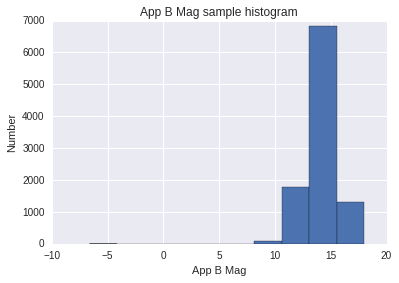

In [16]:
plt.hist(sample['App_Mag'])
plt.xlabel('App B Mag')
plt.ylabel('Number')
plt.title('App B Mag sample histogram')

plt.savefig(os.path.join(plots, 'appmag_sample_histogram.png'), dpi=300)

plt.show()

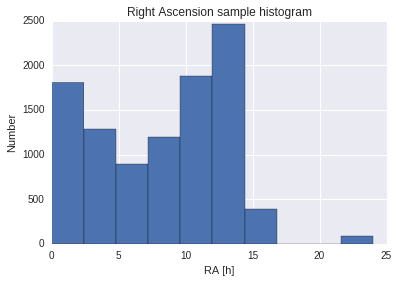

In [17]:
plt.hist(sample['RA'])
plt.xlabel('RA [h]')
plt.ylabel('Number')
plt.title('Right Ascension sample histogram')

plt.savefig(os.path.join(plots, 'RA_sample_histogram.png'), dpi=300)

plt.show()

115.0 -31.4


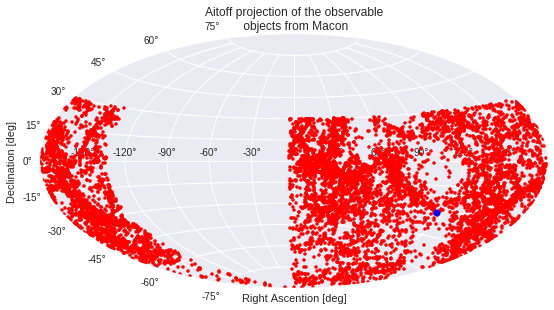

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="aitoff")
deg2rad=np.pi/180.

x = sample['RA']*15.*deg2rad
xg = []
for ax in x:
    if ax > m.pi:
        ax = ax - 2*m.pi
    xg.append(ax)


yg = sample['Dec']*deg2rad

ramax = alpha_observable_max.hour
if alpha_observable_min.hour > 12. : 
    ramin = alpha_observable_min.hour - 24.
else:
    ramin = alpha_observable_min.hour
    
mean_zenith_ra = ((ramax-ramin)*15./2.)

zenith_dec = float(ephem.degrees(macon.lat*180./m.pi))

print mean_zenith_ra, zenith_dec

# we should avoid the galactic plane
plt.plot(xg,yg, "r.")

plt.plot(mean_zenith_ra*deg2rad, zenith_dec*deg2rad, 'bo' )
plt.grid(True)
plt.title("Aitoff projection of the observable\n objects from Macon")
plt.xlabel("Right Ascention [deg]")
plt.ylabel("Declination [deg]")
plt.savefig(os.path.join(plots, 'radec_aitoff_sample.png'), dpi=300)
plt.show()

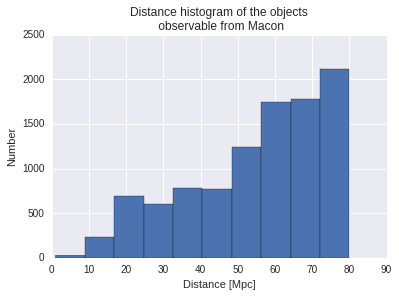

In [20]:
plt.hist(sample['Dist'], range=[1,dist_lim])
plt.title('Distance histogram of the objects\n observable from Macon')

plt.xlabel('Distance [Mpc]')
plt.ylabel('Number')

plt.savefig(os.path.join(plots, 'distance_histogram_sample.png'), dpi=300)

plt.show()

In [21]:
import healpy as hp

In [22]:
aligo_alert_data_file=os.path.join(data_path,"skymap.fits")
NSIDE=512 #2048
aligo_banana = hp.read_map(aligo_alert_data_file)

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [23]:
from astropy.io import fits
hdr1 = fits.getheader(aligo_alert_data_file)

In [24]:
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


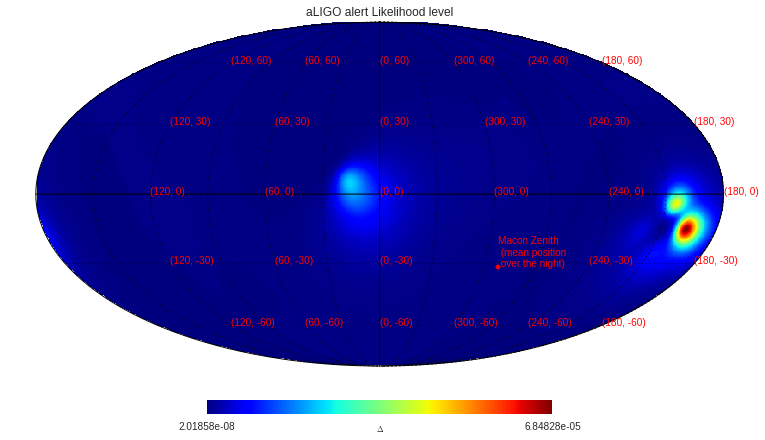

In [30]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
hp.mollview(aligo_banana, title='aLIGO alert Likelihood level', flip="astro",
            unit='$\Delta$', fig=2)
fig.axes[1].texts[0].set_fontsize(8)

#mean_zenith_ra = 15.*(alpha_observable_max.hour+alpha_observable_min.hour)/2.
#zenith_dec = float(ephem.degrees(macon.lat*180./m.pi))

hp.projscatter(mean_zenith_ra, zenith_dec
               , lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")
for ra in range(0,360,60):
    for dec in range(-60,90,30):
        if not (ra == 300 and dec == -30):
                hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap.png'), dpi=300)
plt.show()

50.5891087121 129.410891288 -39.4108912879 39.4108912879
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 4 deg 0.00'.


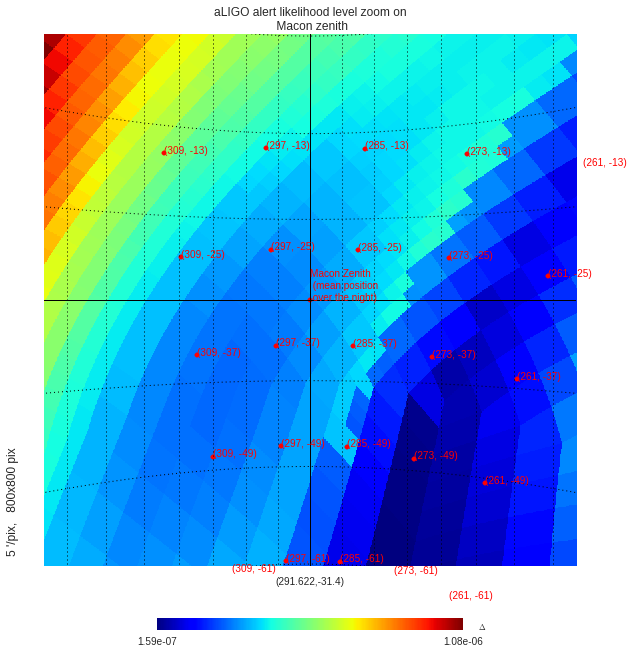

In [28]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
rot=[mean_zenith_ra, zenith_dec]
hp.gnomview(aligo_banana, rot=rot, title='aLIGO alert likelihood level zoom on\n Macon zenith', flip="astro",
            unit='$\Delta$', fig=2, xsize=800, reso=5)
fig.axes[1].texts[0].set_fontsize(8)

hp.projscatter(rot, lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(int(mean_zenith_ra)-30, int(mean_zenith_ra)+30, 12):
    for dec in range(int(zenith_dec)-30, int(zenith_dec)+30, 12):
        hp.projscatter(ra, dec, lonlat=True, color="red")
        hp.projtext(ra, dec, '({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'gnomom_view_Macon_likelihoodmap.png'), dpi=300)

plt.show()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


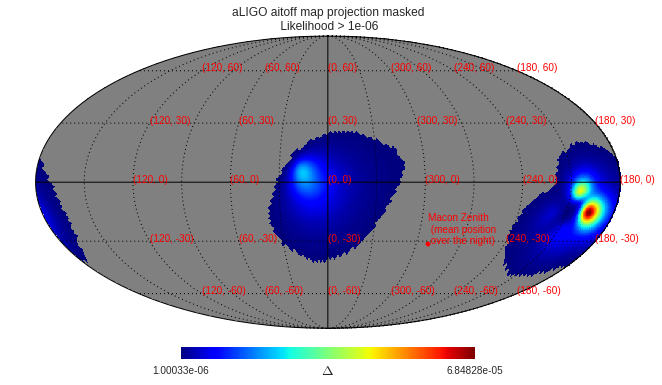

In [29]:
likehood_cut=0.000001 #ut level for mask buildup

aligo_alert_map_high_like = np.logical_not(aligo_banana < likehood_cut)
map_lik_masked = hp.ma(aligo_banana)
map_lik_masked.mask = np.logical_not(aligo_alert_map_high_like)

hp.mollview(map_lik_masked.filled(), 
            title='aLIGO aitoff map projection masked\n Likelihood > {}'.format(likehood_cut),
            unit='$\Delta$', fig=2)
hp.graticule()
hp.projscatter(mean_zenith_ra, zenith_dec
               , lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(0,360,60):
    for dec in range(-60,80,30):
        if not (ra == 300 and dec == -30):
            hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap_masked.png'), dpi=300)
plt.show()

In [2]:
deg2rad = m.pi/180.

phis = list(sample['RA']*15.*deg2rad)
thetas = list(m.pi/2. - sample['Dec']*deg2rad)

def interp_filter(theta, phi):
    return hp.pixelfunc.get_interp_val(aligo_alert_map_high_like, 
                                       theta, phi, nest=False)

def interp(theta, phi):
    return hp.pixelfunc.get_interp_val(aligo_banana, 
                                       theta, phi, nest=False)

interps_filter = np.asarray(map(interp_filter, thetas, phis))

clipped = np.where(interps_filter > 0.2)

interps = np.asarray(map(interp, thetas, phis))

targets = sample[clipped[0]]

target_liks = interps[clipped[0]]

plt.hist(target_liks, log=True)
plt.show()


NameError: name 'm' is not defined

In [ ]:
targets['Likelihoods'] = target_liks

In [ ]:
print len(targets)

plt.figure(figsize=(10,7))
plt.rcParams.update({"font.size":12})
plt.plot(targets['RA']*15.,targets['Dec'], "ro")
plt.plot(mean_zenith_ra, zenith_dec, 'bo')
plt.xlim(mean_zenith_ra-60, mean_zenith_ra+60)
plt.title("Selected targets near Macon zenith\n with likelihood > {}".format(likehood_cut))
plt.xlabel("RA[deg]")
plt.ylabel("Dec[deg]")
#plt.grid()
plt.savefig(os.path.join(plots, "selected_targets_Ra_dec.png"), dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="mollweide")
deg2rad=m.pi/180.
j=0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360,360)
for row in targets:
        x = np.remainder(row['RA']*15.+360,360) # shift RA values
        if x > 180.: 
            x = x-360. # scale conversion to [-180, 180]
        x=-x    # reverse the scale: East to the left
        xg[j]=x*deg2rad 
        yg[j]=row['Dec']*deg2rad
        #print gx[j], xg[j], yg[j]
        j=j+1
               
plt.plot(xg,yg, "r.")
plt.grid(True)
plt.xlabel("Rigth Ascention (degrees)")
plt.ylabel("Declination (degrees)")
plt.title("Aitoff projection of selected targets\n likelihood > {}".format(likehood_cut))
plt.savefig(os.path.join(plots,"aitoff_selected_targets.png"), dpi=300)
plt.show()

In [ ]:
targets

Uno puede ahora usar las galaxias (visibles) dentro de la mascara y rankearlas como mas le guste.
Se pueden ordenar simplemente por Likehood por ejemplo, ahora dado que van a estar observando varios
telescopios (quizas conviene acordar quien mira quien) y las mejoras de posteriores de las alertas
cambian el negocio substancialmente ademas del input de nuestras mediciones

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5

RAJ2015 = []
DecJ2015 = []
RA = []
Dec = []

for row in targets:
    coord=SkyCoord(ra=row['RA']*u.hourangle, dec=row['Dec']*u.degree, frame='icrs')
    precessed=coord.transform_to(FK5(equinox='J2015.11'))
    
    RAJ2015.append(precessed.to_string('hmsdms').split()[0])
    DecJ2015.append(precessed.to_string('hmsdms').split()[1])
    
    strcoord = coord.to_string('hmsdms')
    RA.append(strcoord.split()[0])
    Dec.append(strcoord.split()[1])
    #print i, coord.to_string('hmsdms'), targetLik[ind], targetMag[ind], RAJ2015[i], DecJ2015[i], name2[ind]


In [ ]:
targets['RAJ2015'] = RAJ2015
targets['DecJ2015'] = DecJ2015
targets['RAJ2000'] = RA
targets['DecJ2000'] = Dec

In [ ]:
targets.rename_column('App_Mag', 'AppMag')
targets.rename_column('Abs_Mag', 'AbsMag')
targets.rename_column('Maj_Diam_a', 'MajDiamA')
targets.rename_column('Min_Diam_b', 'MinDiamB')
targets.rename_column('err_Maj_Diam','ErrMajDiam')
targets.rename_column('err_Min_Diam','ErrMinDiam')
targets.rename_column('err_Dist', 'ErrDist')
targets.rename_column('err_App_Mag', 'ErrAppMag')
targets.rename_column('err_Abs_Mag', 'ErrAbsMag')
targets.rename_column('err_b/a', 'Errb/a')

In [ ]:
targets

In [ ]:
targets.sort(['RAJ2000','Likelihoods'])

In [ ]:
targets

In [ ]:
print "Max RA = {}, Min RA = {}".format(targets['RA'].max(), targets['RA'].min())

I am going to calculate how many objects we will be able to visit, and assume that we have only capability to cover 2 objects per hour.

After that the next step is to make fringe selections and rankings per fringe by Likelihood.

In [ ]:
deltaRA = targets['RA'].max() - targets['RA'].min()

estimated_N_objects = deltaRA/0.5 

print "The maximum number of objects visitable are {}".format(round(estimated_N_objects))

So we choose the above number of objects to work. 

The idea will be to optimize the objects using as primary variable the likelihood, and as a second determiner the sky position.

In [ ]:
import link as ll

In [ ]:
near_filter = targets['Dist']<35.
near_targets= targets[near_filter]

In [ ]:
plt.plot(near_targets['RA'], near_targets['Dec'], 'bo')
plt.show()

In [ ]:
near_targets.sort('Likelihoods')

In [ ]:
plt.plot(far_away['RAJ2000'], far_away['Likelihood'], 'bo')
plt.xlabel('RA')
plt.ylabel('Likelihood')
for source in far_away:
    plt.Annotation(s=source['Name'], xy=(source['RAJ2000'], source['Likelihood']), xycoords='data')
#plt.Annotation(s='hola', xy=(5,0.001), xycoords='data')
plt.show()

In [ ]:
far_away.reverse()

In [ ]:
far_away

In [ ]:

plt.figure(figsize=(14,9))
plt.scatter(np.asarray(far_away['RAJ2000']), np.asarray(far_away['DecJ2000']), s=2E11*far_away['Likelihood']**2., 
            c=far_away['Likelihood'])
plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [ ]:
a_hi = far_away['RAJ2000']<7.
a_lo = far_away['RAJ2000']>0.5
secbin= far_away[a_hi & a_lo]
lik = secbin['Likelihood']

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(np.asarray(secbin['RAJ2000']), np.asarray(secbin['DecJ2000']), s=2E11*secbin['Likelihood']**2., 
            c=secbin['Likelihood'])
for goodies in range(3):
    row = secbin[goodies]
    plt.annotate(s=str(row['Name']), xy=(row['RAJ2000'], row['DecJ2000']))

plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [ ]:
aaa = SkyCoord(ra=secbin[7]['RAJ2000']*u.hourangle, dec=secbin[7]['DecJ2000']*u.degree)
aaa.to_string('hmsdms')

In [ ]:
bbb = SkyCoord(ra=secbin[0]['RAJ2000']*u.hourangle, dec=secbin[0]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

In [ ]:
b_hi = candidates['RAJ2000']<7.5
b_lo = candidates['RAJ2000']>5.5
dist_lo = candidates['Distance']>35.
mag_hi = candidates['Appmag']< 17.
thirdbin= candidates[b_hi & b_lo & mag_hi & dist_lo]
thirdbin.sort('Likelihood')

In [ ]:
bbb = SkyCoord(ra=thirdbin[1]['RAJ2000']*u.hourangle, dec=thirdbin[1]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

In [ ]:
thirdbin

In [ ]:
SkyCoord

In [ ]:
targets.write(os.path.join(plots,'targets_textable.tex'), format='latex')